# Использование обученных моделей

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transfer_model = models.resnet50(pretrained=True) 
print(transfer_model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Фиксирование параметров модели

In [ ]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

## Замена классификатора

In [ ]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2)) 
print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Обучение новой модели

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "/content/drive/My Drive/Colab Notebooks/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "/content/drive/My Drive/Colab Notebooks/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
print(len(train_data_loader.dataset))

809


In [ ]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.01)

In [ ]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

<ipython-input-6-f38d79bc5988>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 5.95, Validation Loss: 0.52, accuracy = 0.86
Epoch: 1, Training Loss: 0.32, Validation Loss: 0.50, accuracy = 0.82
Epoch: 2, Training Loss: 0.14, Validation Loss: 0.39, accuracy = 0.90
Epoch: 3, Training Loss: 0.10, Validation Loss: 0.29, accuracy = 0.89
Epoch: 4, Training Loss: 0.09, Validation Loss: 0.51, accuracy = 0.86
Epoch: 5, Training Loss: 0.08, Validation Loss: 0.49, accuracy = 0.85
Epoch: 6, Training Loss: 0.04, Validation Loss: 0.27, accuracy = 0.92
Epoch: 7, Training Loss: 0.09, Validation Loss: 0.37, accuracy = 0.86
Epoch: 8, Training Loss: 0.05, Validation Loss: 0.14, accuracy = 0.93
Epoch: 9, Training Loss: 0.07, Validation Loss: 0.17, accuracy = 0.95
Epoch: 10, Training Loss: 0.04, Validation Loss: 0.20, accuracy = 0.95
Epoch: 11, Training Loss: 0.05, Validation Loss: 0.13, accuracy = 0.95
Epoch: 12, Training Loss: 0.04, Validation Loss: 0.31, accuracy = 0.93
Epoch: 13, Training Loss: 0.03, Validation Loss: 0.29, accuracy = 0.94
Epoch: 14, Train

## Задание 1
Преобразовать модель ResNet50 под данные Mnist-Fashion, выполнить обучение модели. Оценить качество обучения.

In [ ]:
class NewTransferFromFashionMnist(nn.Module):
  def __init__(self, in_channels=1):
    super(NewTransferFromFashionMnist, self).__init__()
    
    self.model = models.resnet50(pretrained=True)

    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)


transfer_model = NewTransferFromFashionMnist()



In [ ]:
input = torch.randn((16,1,244,244))
output = transfer_model(input)
print(output.shape)

print(transfer_model)

torch.Size([16, 10])
NewTransferFromFashionMnist(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
     

In [ ]:
fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root="sample_data").train_data.float()
    
data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

train_data_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root="sample_data", transform=data_transform, train=True),
                          batch_size=50, shuffle=True)

val_data_loader = DataLoader(torchvision.datasets.FashionMNIST(download=False, root="sample_data", transform=data_transform, train=False),
                        batch_size=50, shuffle=False)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
def train_Mnist(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    losses = []
    batches = len(train_loader)
    val_batches = len(val_loader)

    # цикл для каждого этапа
    for epoch in range(epochs):
        total_loss = 0

        # вкдлючение progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

        # включение обучения
        model.train()
        
        for i, data in progress:
            inputs, targets = data[0].to(device), data[1].to(device)
            model.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            current_loss = loss.item()
            total_loss += current_loss
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
            
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, targets = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                val_losses += loss_fn(outputs, targets)
                predicted_classes = torch.max(outputs, 1)[1] 
          
        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        losses.append(total_loss/batches)

In [ ]:
print(len(train_data_loader.dataset))

60000


In [ ]:
transfer_model.to(device)

optimizer = optim.Adam(transfer_model.parameters(), lr=3e-4)

In [ ]:
train_Mnist(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)

Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/5, training loss: 0.14487579327231895, validation loss: 0.20190738141536713


Loss:   0%|          | 0/1200 [00:00<?, ?it/s]

# Оценка качества обучения:

Модель обучается лучше в том числе из-за большего количества данных в DATASETe. По этой де причине обучение идеит медленнее. 

## Определение параметра скорости обучения

In [ ]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Выход, если ошибка слишком велика

        if batch_num > 1 and loss > 40 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Сохранение наилучшей ошибки

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Заполнение списков ошибок
        losses.append(loss.item())
        log_lrs.append((lr))

        # Обратное распространение ошибки и шаг оптимизатора

        loss.backward()
        optimizer.step()

        # Обновление скорости обучения для следующего шага и сохранение

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses


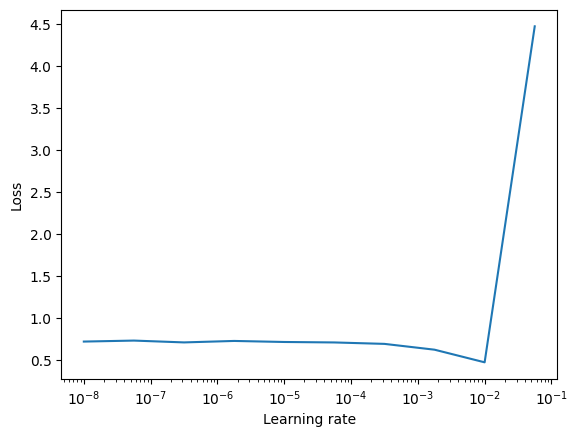

In [ ]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
#plt.ylim(0,2)
plt.show()

In [ ]:
lrs, losses

([1e-08,
  5.6234132519034905e-08,
  3.1622776601683787e-07,
  1.7782794100389223e-06,
  9.999999999999996e-06,
  5.623413251903488e-05,
  0.0003162277660168377,
  0.0017782794100389215,
  0.009999999999999992,
  0.056234132519034856],
 [0.7189668416976929,
  0.7307277321815491,
  0.7089536190032959,
  0.7264268398284912,
  0.7140543460845947,
  0.7085305452346802,
  0.6914305090904236,
  0.6222354769706726,
  0.4717576503753662,
  4.474359035491943])

## Преобразование своим классом

Создадим лямда-преобразование и свой преобразующий данные класс.

In [ ]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output 

In [ ]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [ ]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [ ]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [ ]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, transforms.ToTensor(), Noise(0.1, 0.05)])

## Задание 2
Открыть изображение с диска, визуализировать его. Выполнить преобразование `custom_transform_pipeline` и снова визуализировать.

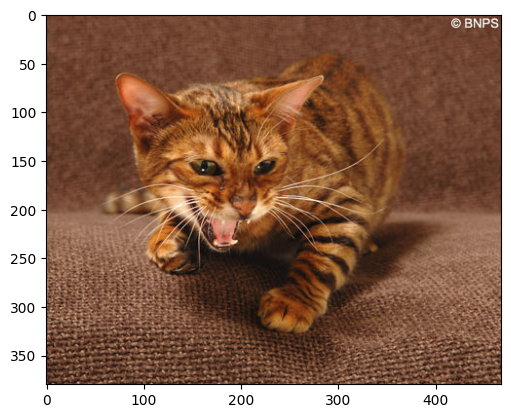

In [ ]:
img=Image.open('/content/drive/My Drive/Colab Notebooks/train/cat/tigercatBNS_468x380.jpg')
plt.imshow(img)

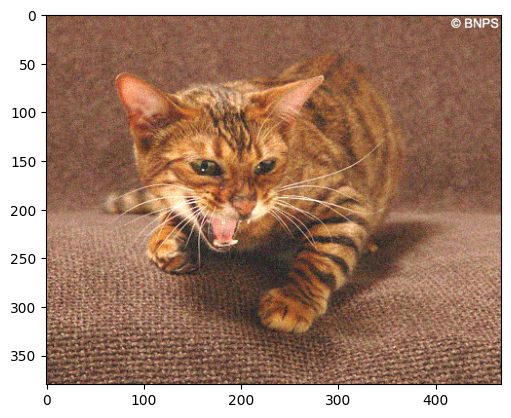

In [ ]:
img1=custom_transform_pipeline(img)
plt.imshow(img1.transpose(0,2).transpose(0,1))

In [ ]:
img1.transpose(0,2).transpose(0,1).shape

torch.Size([380, 468, 3])

## Ансамбли моделей

При наличии списка моделей можно предсказывать на основе усреднения предсказаний каждой модели.

In [ ]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

<ipython-input-67-8d7c1a308d5b>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble]


In [ ]:
avg_prediction

tensor(413, device='cuda:0')

In [ ]:
torch.stack(predictions)

tensor([[[0.0010, 0.0031, 0.0007,  ..., 0.0003, 0.0007, 0.0003]],

        [[0.0017, 0.0003, 0.0009,  ..., 0.0010, 0.0018, 0.0003]]],
       device='cuda:0', grad_fn=<StackBackward0>)

# Задание 3. 
В методе ансамблей сравнить две модели transfer_model и transer_model_drop, в которой отсутсвует слой Dropout. Сравнить предсказания моделей и найти среднее предсказание (avg_prediction).

In [ ]:
transfer_model_drop = models.resnet50(pretrained=True) 
transfer_model_drop.fc = nn.Sequential(nn.Linear(transfer_model_drop.fc.in_features, 500),
nn.ReLU(), nn.Linear(500,2)) 
print(transfer_model_drop)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transfer_model_drop.to(device)
optimizer = optim.Adam(transfer_model_drop.parameters(), lr=0.01)
train(transfer_model_drop, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

<ipython-input-50-f38d79bc5988>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 2.29, Validation Loss: 3535155.19, accuracy = 0.21
Epoch: 1, Training Loss: 0.93, Validation Loss: 468.56, accuracy = 0.79
Epoch: 2, Training Loss: 0.87, Validation Loss: 36.16, accuracy = 0.27
Epoch: 3, Training Loss: 0.65, Validation Loss: 0.65, accuracy = 0.58
Epoch: 4, Training Loss: 0.58, Validation Loss: 0.73, accuracy = 0.59
Epoch: 5, Training Loss: 0.55, Validation Loss: 0.54, accuracy = 0.76
Epoch: 6, Training Loss: 0.51, Validation Loss: 0.45, accuracy = 0.76
Epoch: 7, Training Loss: 0.41, Validation Loss: 0.97, accuracy = 0.57
Epoch: 8, Training Loss: 0.42, Validation Loss: 0.53, accuracy = 0.75
Epoch: 9, Training Loss: 0.40, Validation Loss: 0.81, accuracy = 0.65
Epoch: 10, Training Loss: 0.32, Validation Loss: 1.40, accuracy = 0.39
Epoch: 11, Training Loss: 0.45, Validation Loss: 1.29, accuracy = 0.41
Epoch: 12, Training Loss: 0.37, Validation Loss: 1.26, accuracy = 0.53
Epoch: 13, Training Loss: 0.30, Validation Loss: 0.38, accuracy = 0.81
Epoch: 

In [ ]:
transfer_ensemble = [transfer_model, transfer_model_drop]
predictions_drop = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in transfer_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

<ipython-input-72-50ae718e66c4>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions_drop = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in transfer_ensemble]


In [ ]:
avg_prediction

tensor(413, device='cuda:0')

In [ ]:
torch.stack(predictions_drop)

tensor([[[1.0000e+00, 0.0000e+00]],

        [[1.0317e-05, 9.9999e-01]]], device='cuda:0', grad_fn=<StackBackward0>)